<a href="https://colab.research.google.com/github/PhuongDang1/SIT-Research-Project/blob/main/Artefact/Research_Project%20_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading Relevant Libraries**

In [1]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, GRU,Reshape, Dense
from numpy import array
import tensorflow as tf
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

drive.mount('/content/drive')

Mounted at /content/drive


# **Loading the data into a variable**

In [2]:
dataset = pd.read_excel("/content/drive/My Drive/Covid_Dataset.xlsx")
dataset

,dateRep,cases,deaths,countriesAndTerritories,Population Density 2020 (P/KM2),continentExp,Wind Speed Minimum,Wind Speed Maximum,Wind Speed Median,Wind Speed Variance
0,2019-12-31,0,0,India,464,Asia,0.4,2.2,1.7,3.58
1,2020-01-01,0,0,India,464,Asia,0.5,2.6,0.8,4.89
2,2020-01-02,0,0,India,464,Asia,0.5,1.6,0.7,1.40
3,2020-01-03,0,0,India,464,Asia,0.1,9.9,0.9,20.86
4,2020-01-04,0,0,India,464,Asia,0.1,11.8,0.8,20.96
...,...,...,...,...,...,...,...,...,...,...
1387,2020-12-10,220025,3124,United_States_of_America,36,America,0.1,18.0,3.8,114.01
1388,2020-12-11,224680,2748,United_States_of_America,36,America,0.1,12.0,2.5,51.39
1389,2020-12-12,234633,3343,United_States_of_America,36,America,0.1,8.5,2.5,25.50
1390,2020-12-13,216017,2315,United_States_of_America,36,America,0.8,15.0,3.6,77.38


# **Preprocessing for confirmed cases test only**

In [3]:
new_index = dataset.iloc[:,0]
new_index
values = dataset.set_index(new_index)
values = values.iloc[:,1:]
values = values.iloc[:1500,0:2].astype('float32')
values
labels = dataset.iloc[:1500,-9]
labels

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(values, labels, test_size=0.20, random_state=88)

In [4]:
train_labels = pd.array(train_labels)
test_labels = pd.array(test_labels)

In [5]:
train = train_data
scalers={}
for i in train_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_data
for i in test_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [6]:
def split_series(series, n_past, n_future):
  # n_past ==> no of past observations
  # n_future ==> no of future observations 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [7]:
n_past = 10
n_future = 20
n_features = 2

In [8]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# **Designing the Model of LSTM**

In [15]:
#LSTM
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(2, activation='tanh',return_state=True) 
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_LSTM = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_LSTM.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 2), (None, 2 40          input_3[0][0]                    
__________________________________________________________________________________________________
repeat_vector_2 (RepeatVector)  (None, 20, 2)        0           lstm_4[0][0]                     
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 20, 2)        40          repeat_vector_2[0][0]            
                                                                 lstm_4[0][1]               

In [16]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# **Training of LSTM and evaluation**

In [17]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

#loss test
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_LSTM.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])
#model_LSTM.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

history_LSTM = model_LSTM.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
44/44 [==============================] - 4s 32ms/step - loss: 0.6065 - accuracy: 0.4565 - mean_squared_error: 0.6065 - val_loss: 0.4885 - val_accuracy: 0.4138 - val_mean_squared_error: 0.4885
Epoch 2/100
44/44 [==============================] - 1s 14ms/step - loss: 0.3821 - accuracy: 0.4589 - mean_squared_error: 0.3821 - val_loss: 0.2763 - val_accuracy: 0.4228 - val_mean_squared_error: 0.2763
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.2184 - accuracy: 0.4611 - mean_squared_error: 0.2184 - val_loss: 0.1601 - val_accuracy: 0.4262 - val_mean_squared_error: 0.1601
Epoch 4/100
44/44 [==============================] - 1s 12ms/step - loss: 0.1391 - accuracy: 0.4626 - mean_squared_error: 0.1391 - val_loss: 0.1081 - val_accuracy: 0.4338 - val_mean_squared_error: 0.1081
Epoch 5/100
44/44 [==============================] - 1s 12ms/step - loss: 0.1044 - accuracy: 0.4649 - mean_squared_error: 0.1044 - val_loss: 0.0850 - val_accuracy: 0.4336 - val_mean_sq

In [18]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_LSTM.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.517400
Error Rate: 0.482600
Mean Squared Error: 0.059222


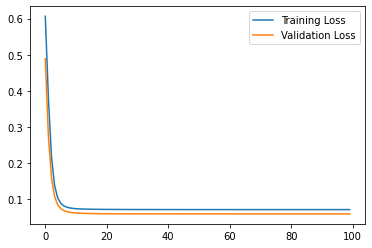

In [19]:
pred_LSTM=model_LSTM.predict(X_test)
#LSTM
plt.plot(history_LSTM.history["loss"], label="Training Loss")
plt.plot(history_LSTM.history["val_loss"], label="Validation Loss")
plt.legend()

# **Training of GRU and evaluation**

In [20]:
# GRU
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.GRU(2,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.GRU(2, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_GRU = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_GRU.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 2)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 10, 2), (Non 36          input_4[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 2), (None, 2 36          gru[0][0]                        
__________________________________________________________________________________________________
repeat_vector_3 (RepeatVector)  (None, 20, 2)        0           gru_1[0][0]                      
____________________________________________________________________________________________

In [21]:
#loss test
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_GRU.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compilee(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

In [22]:
model_GRU.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy','mean_squared_error'])
history_GRU = model_GRU.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
44/44 [==============================] - 8s 52ms/step - loss: 0.7229 - accuracy: 0.5276 - mean_squared_error: 0.7229 - val_loss: 0.6252 - val_accuracy: 0.5362 - val_mean_squared_error: 0.6252
Epoch 2/100
44/44 [==============================] - 1s 26ms/step - loss: 0.5485 - accuracy: 0.5179 - mean_squared_error: 0.5485 - val_loss: 0.4743 - val_accuracy: 0.5424 - val_mean_squared_error: 0.4743
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3999 - accuracy: 0.5238 - mean_squared_error: 0.3999 - val_loss: 0.3188 - val_accuracy: 0.5562 - val_mean_squared_error: 0.3188
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2488 - accuracy: 0.5343 - mean_squared_error: 0.2488 - val_loss: 0.1740 - val_accuracy: 0.5708 - val_mean_squared_error: 0.1740
Epoch 5/100
44/44 [==============================] - 1s 26ms/step - loss: 0.1400 - accuracy: 0.5353 - mean_squared_error: 0.1400 - val_loss: 0.1024 - val_accuracy: 0.5730 - val_mean_sq

In [23]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_GRU.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.550400
Error Rate: 0.449600
Mean Squared Error: 0.060094


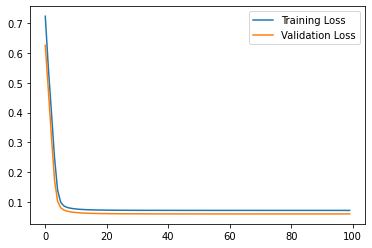

In [24]:
pred_LSTM=model_GRU.predict(X_test)
#GRU with factors
plt.plot(history_GRU.history["loss"], label="Training Loss")
plt.plot(history_GRU.history["val_loss"], label="Validation Loss")
plt.legend()

# **Preprocessing for confirmed cases with Wind Speed and Population density factors**

In [25]:
new_index = dataset.iloc[:,0]
new_index
values = dataset.set_index(new_index)
values = values.iloc[:,1:]
values = values.iloc[:1500,[0,1,3,5,6,7,8]].astype('float32')
values
labels = dataset.iloc[:1500,-9]
labels

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(values, labels, test_size=0.20, random_state=88)

In [26]:
train_labels = pd.array(train_labels)
test_labels = pd.array(test_labels)

In [27]:
train = train_data
scalers={}
for i in train_data.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_data
for i in test_data.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s= np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [ ]:
def split_series(series, n_past, n_future):
  # n_past ==> no of past observations
  # n_future ==> no of future observations 
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
n_past = 10
n_future = 20
n_features = 7

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

# **Designing the Model of LSTM**

In [ ]:
#LSTM
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(2, activation='tanh',return_state=True) 
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
decoder_l1 = tf.keras.layers.LSTM(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
model_LSTM2 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

model_LSTM2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 2), (None, 2 80          input_7[0][0]                    
__________________________________________________________________________________________________
repeat_vector_6 (RepeatVector)  (None, 20, 2)        0           lstm_12[0][0]                    
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 20, 2)        40          repeat_vector_6[0][0]            
                                                                 lstm_12[0][1]              

In [ ]:
from keras import backend as K

def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

# **Training the Model of LSTM using factors and evaluation**

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

#loss test
model_LSTM2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_LSTM2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_LSTM2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_LSTM2.compile(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

history_LSTM2 = model_LSTM2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=25,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
44/44 [==============================] - 5s 31ms/step - loss: 0.6742 - accuracy: 0.4076 - mean_squared_error: 0.6742 - val_loss: 0.6429 - val_accuracy: 0.3892 - val_mean_squared_error: 0.6429
Epoch 2/100
44/44 [==============================] - 1s 14ms/step - loss: 0.6032 - accuracy: 0.1961 - mean_squared_error: 0.6032 - val_loss: 0.5819 - val_accuracy: 0.0040 - val_mean_squared_error: 0.5819
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.5370 - accuracy: 0.0018 - mean_squared_error: 0.5370 - val_loss: 0.5027 - val_accuracy: 0.0040 - val_mean_squared_error: 0.5027
Epoch 4/100
44/44 [==============================] - 1s 14ms/step - loss: 0.4328 - accuracy: 0.0018 - mean_squared_error: 0.4328 - val_loss: 0.3889 - val_accuracy: 0.0040 - val_mean_squared_error: 0.3889
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.3362 - accuracy: 0.0018 - mean_squared_error: 0.3362 - val_loss: 0.3156 - val_accuracy: 0.0040 - val_mean_sq

In [ ]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_LSTM2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.693400
Error Rate: 0.306600
Mean Squared Error: 0.148720


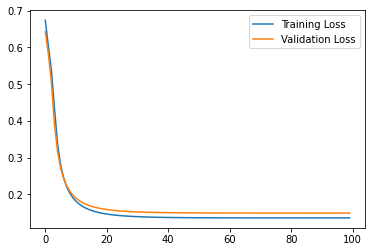

In [ ]:
pred_LSTM=model_LSTM2.predict(X_test)
#LSTM
plt.plot(history_LSTM2.history["loss"], label="Training Loss")
plt.plot(history_LSTM2.history["val_loss"], label="Validation Loss")
plt.legend()

# **Designing of GRU model using factors**

In [ ]:
# GRU
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.GRU(2,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]

encoder_l2 = tf.keras.layers.GRU(2, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
decoder_l1 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.GRU(2, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_GRU2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_GRU2.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       [(None, 10, 2), (Non 66          input_8[0][0]                    
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 2), (None, 2 36          gru[0][0]                        
__________________________________________________________________________________________________
repeat_vector_7 (RepeatVector)  (None, 20, 2)        0           gru_1[0][0]                      
____________________________________________________________________________________________

In [ ]:
#loss test
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_GRU2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.binary_crossentropy,metrics=['accuracy',mean_squared_error])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy',mean_squared_error])
#model_GRU.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1e-3), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy',mean_squared_error])

#optimizer test
#model_GRU.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy', 'mean_squared_error'])
#model_GRU.compilee(optimizer=tf.keras.optimizers.Adadelta(learning_rate=.1e-3), loss=tf.keras.losses.Huber(),metrics=['accuracy',mean_squared_error])

# **Training the Model of LSTM using factors and evaluation**

In [ ]:
model_GRU2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy','mean_squared_error'])
history_GRU2 = model_GRU2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/100
34/34 [==============================] - 9s 68ms/step - loss: 0.6271 - accuracy: 0.4058 - mean_squared_error: 0.6271 - val_loss: 0.5597 - val_accuracy: 0.5908 - val_mean_squared_error: 0.5597
Epoch 2/100
34/34 [==============================] - 1s 30ms/step - loss: 0.4989 - accuracy: 0.6012 - mean_squared_error: 0.4989 - val_loss: 0.4417 - val_accuracy: 0.6248 - val_mean_squared_error: 0.4417
Epoch 3/100
34/34 [==============================] - 1s 31ms/step - loss: 0.3886 - accuracy: 0.6250 - mean_squared_error: 0.3886 - val_loss: 0.3416 - val_accuracy: 0.6256 - val_mean_squared_error: 0.3416
Epoch 4/100
34/34 [==============================] - 1s 31ms/step - loss: 0.3030 - accuracy: 0.6257 - mean_squared_error: 0.3030 - val_loss: 0.2725 - val_accuracy: 0.6264 - val_mean_squared_error: 0.2725
Epoch 5/100
34/34 [==============================] - 1s 31ms/step - loss: 0.2467 - accuracy: 0.6357 - mean_squared_error: 0.2467 - val_loss: 0.2303 - val_accuracy: 0.6590 - val_mean_sq

In [ ]:
from sklearn.metrics import mean_squared_error
loss, accuracy,mean_squared_error = model_GRU2.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % accuracy)
print('Error Rate: %f' % (1 - accuracy))
print('Mean Squared Error: %f' % mean_squared_error)

Accuracy: 0.693400
Error Rate: 0.306600
Mean Squared Error: 0.146006


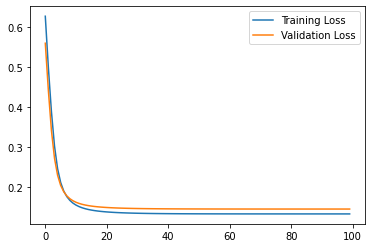

In [ ]:
pred_LSTM=model_GRU2.predict(X_test)
#GRU with factors
plt.plot(history_GRU2.history["loss"], label="Training Loss")
plt.plot(history_GRU2.history["val_loss"], label="Validation Loss")
plt.legend()